# L'objectif de cette partie est  d'étudier l'élasticité prix de la demande et de visualiser le graphe de top_k_client-produits

# PLan
   # I. Analyse et prétraitement des données
      # I.1 Nettoyage des données
      # I.2 Clustering
   # II. L'elasticité prix de la demande
     #  II.1 L'elasticité prix directe
     #  II.2 L'elasticité prix croisée
   # III. Le graphe client-produits
    #    III.1 Le top_k des clients
    #    III.2 visualisation du graphe

# FD############################################################FD

#  I. Analyse et Prétraitement des données

   # I.1 Nettoyage de données

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore') 

        # Nous allons néttoyer ici les données aberrantes(Prix négatif ou Quantité négative)  

In [262]:
# load data: la base des transaction
data=  pd.read_csv(r"data.csv", sep=",", encoding ='latin1')
data =  data[(data["UnitPrice"] > 0.00) & (data["Quantity"] > 0.00) ] #Nettoyer les donnée
data1 =data.head(10000)
data.shape

(530104, 8)

    #Nous allons visualiser la distibution du prix unitaire, pour avoir une meilleure approche des données

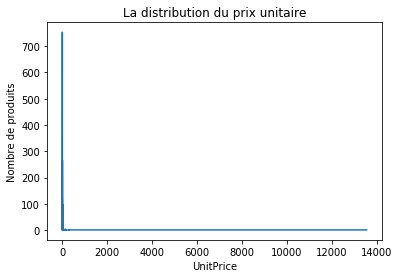

In [286]:
#la variation des prix
Price_number =  data[["StockCode", "UnitPrice"]].drop_duplicates().groupby(["UnitPrice"]).count()
plt.plot(Price_number)
plt.xlabel("UnitPrice")
plt.ylabel("Nombre de produits")
plt.title("La distribution du prix unitaire")
plt.show()

    #Vous remarquez que le prix est concentré entre 0 et 50.

# I.2 Clustering

    # Nous allons utiliser le clustering pour organiser des données brutes en silos homogènes selon le prix unitaire et la quantité vendue. 

In [288]:
X1 = data1[["Quantity", "UnitPrice"]].values #Recuperer le prix et la quantité
X1 =  X1.astype(float)
X = data[[ "UnitPrice"]].values
X =  X.astype(float)

    #Le dendrogramme permet de trouver le nombre de classe optimal pour le clustering

<Figure size 1440x720 with 0 Axes>

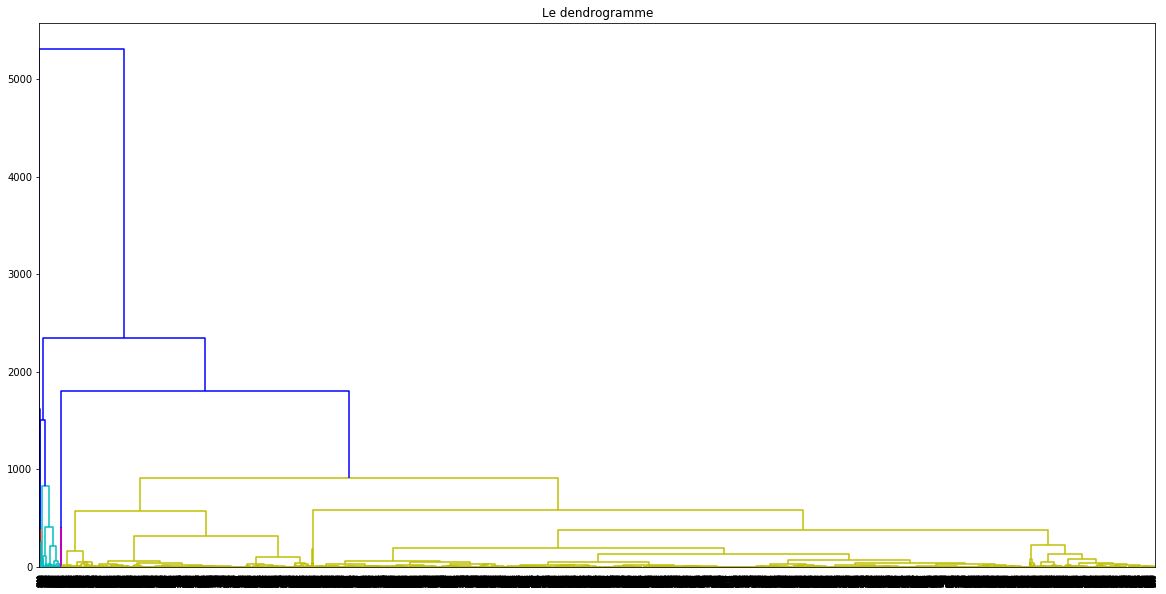

In [289]:
# Nous utilise les le dendogram pour trouver le nombre de classe optimal
from  scipy.cluster.hierarchy import dendrogram, linkage 
plt.figure(figsize=(20,10))
Z = linkage(X1, 'ward')
dn = dendrogram(Z,color_threshold=1000)
plt.title("Le dendrogramme")
plt.show()

Le dendrogramme nous montre 3 principales couleurs. Donc le nombre de classe optimal est de 3.

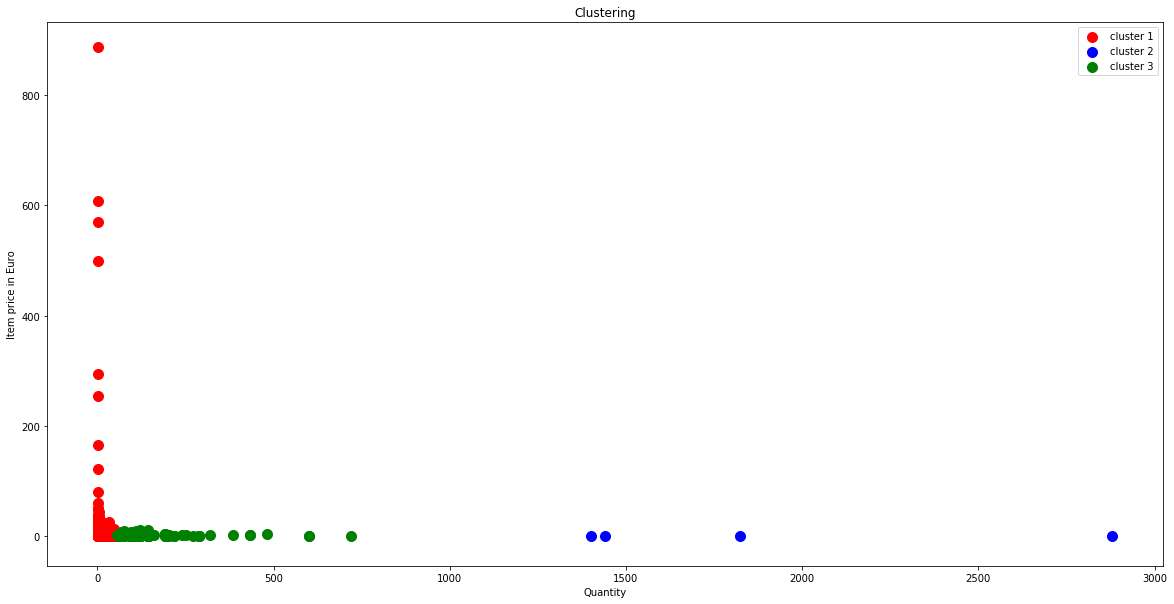

In [291]:
# lE nombre de cluster optimal est de 3

from sklearn.cluster import AgglomerativeClustering
cls = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
Y_cls = cls.fit_predict(X1) 
plt.figure(figsize=(20,10))
plt.scatter(X1[Y_cls == 0,0], X1[Y_cls == 0,1], s=100,  c='red', label = "cluster 1" )
plt.scatter(X1[Y_cls == 1,0], X1[Y_cls == 1,1], s=100,  c='blue', label = "cluster 2" )
plt.scatter(X1[Y_cls == 2,0], X1[Y_cls == 2,1], s=100,  c='green', label = "cluster 3" )
plt.title('Clustering')
plt.xlabel('Quantity')
plt.ylabel('Item price in Euro')
plt.legend()
plt.show()


In [3]:
data.shape

(541909, 8)

In [11]:
#Nous allons d'abrd analyser les  données
produits = data[["StockCode"]].drop_duplicates()
print(produits.count())

StockCode    3922
dtype: int64


# II. L'élasticité prix 

L’élasticité prix est un élément important à prendre en compte dans le cadre de la politique de prix
et certaines actions marketing (voir plus bas l’impact de la publicité TV) peuvent chercher à réduire
l’élasticité prix de manière à pouvoir augmenter les marges sans trop impacter le chiffre d’affaires.

    # Nous allons d'abord récuperer les "StockCode des produits qui ont connu un changement de prix (noté a)

In [290]:
#Récuperer les produits qui ont connu un changeement de prix
produitsUnit = data1[["StockCode", "UnitPrice"]].drop_duplicates().groupby(["StockCode"])
produits= produitsUnit.count()
produits_StockCode = produits[produits["UnitPrice"]> 1].index.values
print(produits_StockCode) # Afficher les stockCode pour vérifier

['10002' '10133' '10135' '11001' '15036' '15056BL' '15056N' '15056P'
 '15060B' '16235' '16237' '16238' '17003' '17090A' '17091J' '18098C'
 '20615' '20616' '20655' '20658' '20668' '20669' '20676' '20679' '20681'
 '20682' '20684' '20685' '20686' '20699' '20711' '20712' '20717' '20718'
 '20719' '20723' '20724' '20725' '20726' '20727' '20728' '20735' '20749'
 '20750' '20752' '20754' '20770' '20772' '20780' '20867' '20902' '20914'
 '20956' '20961' '20963' '20966' '20969' '20970' '20971' '20972' '20973'
 '20974' '20975' '20981' '20992' '21025' '21035' '21041' '21055' '21067'
 '21068' '21069' '21070' '21071' '21078' '21080' '21086' '21094' '21098'
 '21100' '21107' '21108' '21109' '21110' '21111' '21112' '21115' '21116'
 '21121' '21122' '21137' '21147' '21154' '21155' '21156' '21157' '21158'
 '21164' '21165' '21166' '21169' '21174' '21175' '21181' '21191' '21192'
 '21195' '21207' '21210' '21212' '21213' '21215' '21216' '21217' '21218'
 '21221' '21224' '21231' '21232' '21238' '21239' '21240' '2

# 1) L'élasticité-prix directe

        L'élasticité prix directe nous permet donc de connaître l'évolution de la quantité vendue à la suite d'une variation
        des prix. 

# quantity_price function
    description : Visualisation de la quantité vendues en fonction du prix
    params:
        UnitCode ={Desc: le StockCode du produit à étudier, Type: String}
        data= {Desc: la base des transactions,Type : DataFrame}
   

In [72]:
def quantity_price(unitcode,data): 
    Select_Produit = data[data["StockCode"] == unitcode]
    #Pour chaque prix on calcule la moyenne de la quantité vendue
    Price_quantity =  Select_Produit[["Quantity", "UnitPrice"]].groupby("UnitPrice").agg("mean")
    plt.figure(figsize=(20,10))
    plt.plot(Price_quantity)
    plt.xlabel("Price")
    plt.ylabel("Quantity")
    plt.title("Evolution de la Quantité vendue en fonction du changement de prix du produits x")
    plt.show()


   # elasticite_directe function
    description : Calculer l'elasticité-prix directe 
    params:
        UnitCode ={Desc: le StockCode du produit à étudier, Type: String}
        data= {Desc: la base des transactions,Type : DataFrame}
   
Calcul de l'élasticité prix:  
        La formule de calcul est la suivante: Variation de la consommation / variation des prix.
        Pour calculer chaque variation, on utilise la formule du taux de variation:
        [(Va – Vd) / Vd] x 100

In [20]:
# Calculer l'élasticité-prix directe
def elasticite_directe(unitcode,data):
    Select_Produit = data[data["StockCode"] == unitcode]
    Y=[]
    Price_quantity =  Select_Produit[["Quantity", "UnitPrice"]].groupby("UnitPrice").agg("mean") 
    X = Price_quantity.index.values
    Y  = [ Price_quantity.iloc[i].values.astype(float) for i in range(len(X))]
    el = [ (Y[i]-Y[i+1])/Y[i] for i in range(len(X)-1)] # Calculer l'elasticité à chaque changement de prix
    X_label = [ (X[i],X[i+1])  for i in range(len(X)-1)] # R
    print(X_label)
    print(el)

#Nous allons visualiser les resultatas dans un graphe

[(1.6299999999999999, 1.6499999999999999), (1.6499999999999999, 1.95), (1.95, 4.1299999999999999), (4.1299999999999999, 4.21)]
[array([-29.56234719]), array([ 0.96383929]), array([ 0.84790123]), array([ 0.09090909])]


    #Nous allons visualiser la variation  de la quantité vendue en fonction du prix de deux produits choisis parmi (a)

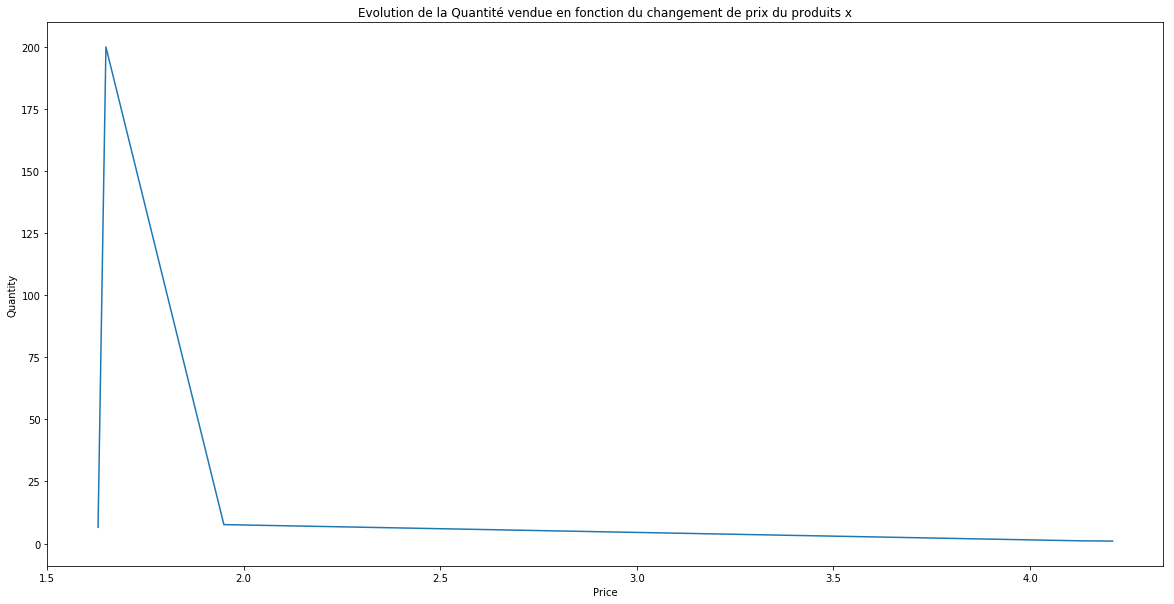

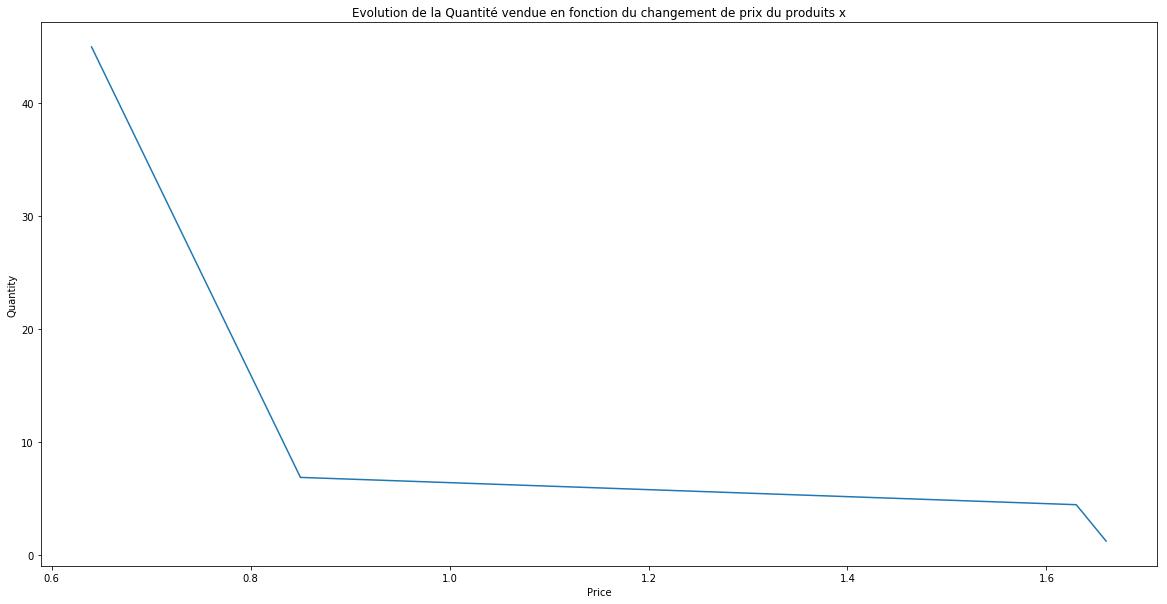

In [226]:
#Visualiser la variation de la quantité vendue
quantity_price("22653",data)
quantity_price("17129F",data)

   # Interpréttion des deux visualisations: 
    L’élasticité-prix directe est négative car la quantité vendue baisse lorsqu’un prix augmente.

# 2) L’élasticité-prix croisée


    Il est possible que la consommation d’un bien ou d’un service varie non pas parce que le prix du
    bien en question a changé, mais parce que le prix d’un autre bien ou service a varié. 

In [15]:
# Nons allons calculer le  croisée au sein de chaque cluster 
dataX = data1.ix[:, 0:7].values
data_cluster  = np.concatenate((data1,Y_cls[:,None]), axis=1)
dataCluster= pd.DataFrame(data_cluster, columns=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
                                                   'UnitPrice', 'CustomerID', 'Country', 'Cluster'])

#Conversion de la variable date
dataCluster["InvoiceDate"] = pd.to_datetime(dataCluster['InvoiceDate'])
dataCluster["InvoiceDate"]  = [time.date() for time in dataCluster["InvoiceDate"]]


# variation function
    description : Visualisation la variation du prix d'un produit en fonction du temps
    params:
        UnitCode ={Desc: le StockCode du produit choisi, Type: String}
        dataCluster= {Desc: la base des transactions,Type : DataFrame}

In [227]:
# sélectioner le produit
import matplotlib.dates as mdates
def variation(unitcode,dataCluster):
    produit  = dataCluster[dataCluster['StockCode']==unitcode]
    produitPD = produit[['InvoiceDate','UnitPrice']].drop_duplicates(['InvoiceDate','UnitPrice'])
    plt.figure(figsize=(20,10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(produitPD['InvoiceDate'],produitPD['UnitPrice'])
    plt.gcf().autofmt_xdate()
    plt.xlabel("Date",fontsize=13)
    plt.ylabel("prix",fontsize=13)
    plt.title("La variation du prix")
    plt.show()


   # elasCroisee function
    description :  Visualisation de la quantité vendues des autres produits du cluster en fonction du prix d'un produit
    params:
        UnitCode ={Desc: le StockCode du produit choisi, Type: String}
        data= {Desc: la base des transactions,Type : DataFrame}

In [228]:
def elasCroisee(unitcode,dataCluster):
    produit  = dataCluster[dataCluster['StockCode']==unitcode]
    date1 =produit['InvoiceDate'].max()
    date2 = produit['InvoiceDate'].min()
    clusterPr  = produit['Cluster'].max()
    clusterPrduits  = dataCluster[  (dataCluster["InvoiceDate"] >= date2 )
                        & (dataCluster["InvoiceDate"] <= date1 )
                        & (dataCluster["Cluster"] == clusterPr )].groupby("StockCode")
    plt.figure(figsize=(20,10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    for dt in produit['InvoiceDate'].values :
        plt.axvline(x=dt, color='red', linestyle='--')
    for pr in clusterPrduits:
        plt.plot(pr[1]["InvoiceDate"],pr[1]["Quantity"])
    plt.gcf().autofmt_xdate()
    plt.show()

# elasticity function
    description :  Calculer l'elasticité croisée au sein d'un cluster
    params:
        UnitCode ={Desc: le StockCode du produit choisi, Type: String}
        data= {Desc: la base des transactions,Type : DataFrame}

In [229]:
def elasticity(unitcode, dataCluster):
    produit  = dataCluster[dataCluster['StockCode']==unitcode]
    date1 =produit['InvoiceDate'].max()
    date2 = produit['InvoiceDate'].min()
    clusterPr  = produit['Cluster'].max()
    clusterProduits  = dataCluster[  (dataCluster["InvoiceDate"] >= date2 )
                        & (dataCluster["InvoiceDate"] <= date1 )
                        & (dataCluster["Cluster"] == clusterPr )].groupby("StockCode")

    result = []
    for pr in clusterProduits:
        pr[1]["Quantity"] = pr[1]["Quantity"].astype(float)
        pr1= pr[1][["InvoiceDate","Quantity"]].groupby("InvoiceDate").agg("mean")
        if len(pr1) > 1:
                X = pr1.index.values
                Y  = [ pr1.iloc[i].values.astype(float) for i in range(len(X))]
                el = [ 100*(Y[i]-Y[i+1])/Y[i] for i in range(len(X)-1)] # Calculer l'elasticité à chaque changement de prix
                X_label = [str(X[i])+" "+str(X[i+1])  for i in range(len(X)-1)] # R
                for i in range(len(el)) :
                        result.append((pr[0],X_label[i],el[i]))
    resultdf = pd.DataFrame(result, columns = ["StockCode", "Date_intervalle", "elasticite"])
    return resultdf[resultdf["elasticite"]!=0.0]
                    

# draw_elasticity function
    description :  Visualiser l'elasticité croisée au sein d'un cluster
    params:
        UnitCode ={Desc: le StockCode du produit choisi, Type: String}
        data= {Desc: la base des transactions,Type : DataFrame}

In [242]:
def draw_elasticity(unitcode, dataCluster):
    df = elasticity(unitcode, dataCluster)
    df = df[["StockCode", "Date_intervalle", "elasticite"]].groupby("StockCode")
    plt.figure(figsize=(15,10))
    for pr in df:
        plt.scatter(pr[1]["Date_intervalle"],pr[1]["elasticite"], label = pr[1][["StockCode"]])
    plt.title('Elasticité croisée')
    plt.show()

In [202]:
produit  = dataCluster[dataCluster['StockCode']=="22086"]
produit[['InvoiceDate','UnitPrice']].drop_duplicates(['InvoiceDate','UnitPrice'])

,InvoiceDate,UnitPrice
46,2010-12-01,2.55
122,2010-12-01,2.95
1501,2010-12-01,5.91
3476,2010-12-02,2.95
4549,2010-12-02,2.55
5319,2010-12-03,2.95
5757,2010-12-03,5.91
6866,2010-12-03,6.77
7387,2010-12-05,2.55
7562,2010-12-05,2.95


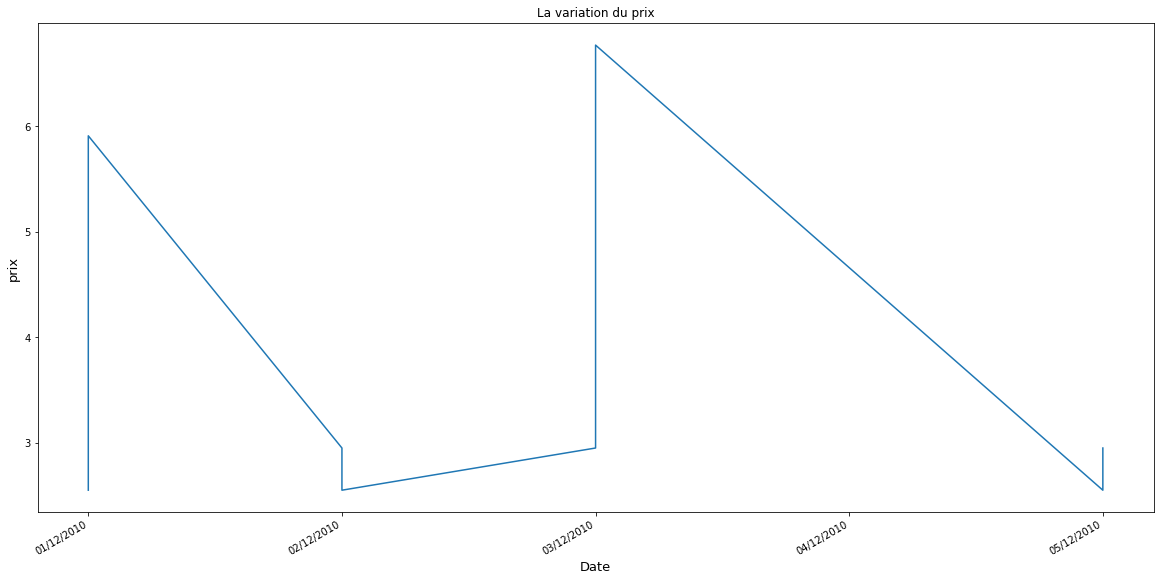

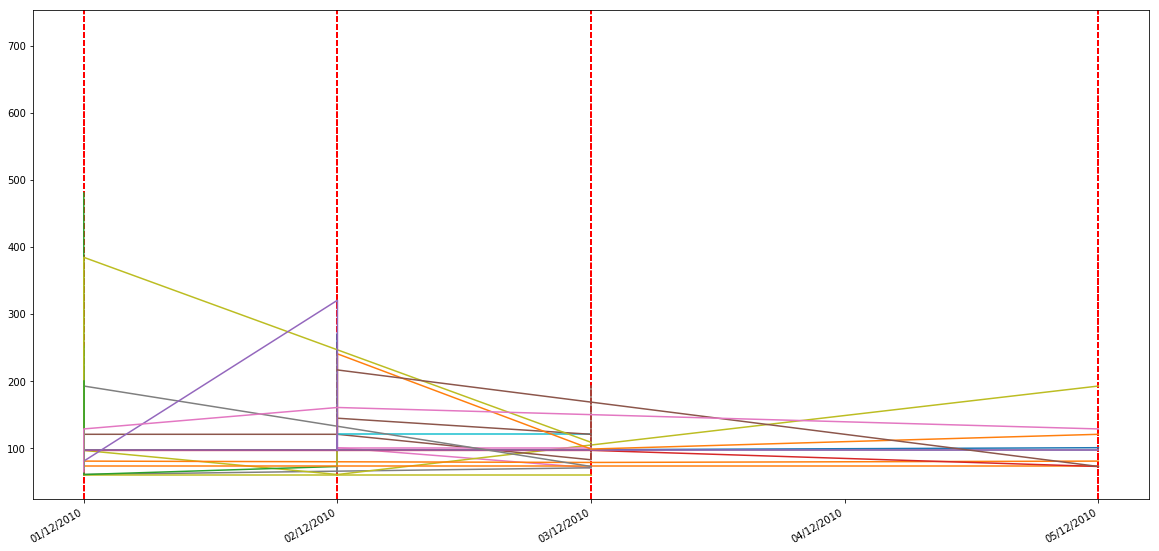

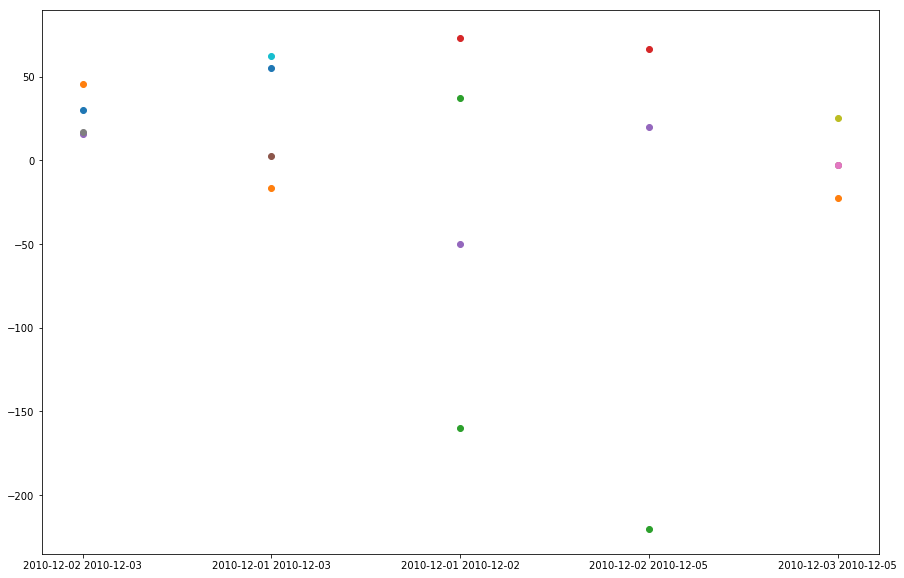

In [243]:
# Nous allon tester nos fonction sur un produit
variation("22086",dataCluster)
elasCroisee("22086",dataCluster)
draw_elasticity("22086",dataCluster)

# Interprétation :
Cette dernère représente l'etasticité croisée. Si on fixe le seuil à -50 pour les produits complémentaires, on remarque que le produit 22086 a trois produits complémentaires.Et si le seuil est de 50 pour les produts de subtitution, il en a 4. Le reste sont des produit indépendants

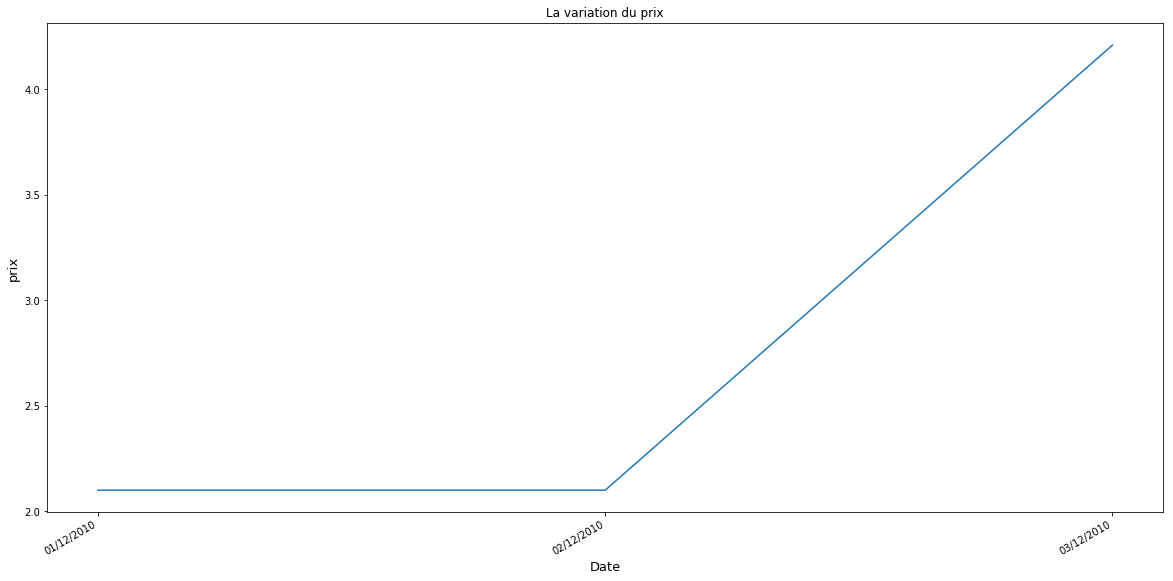

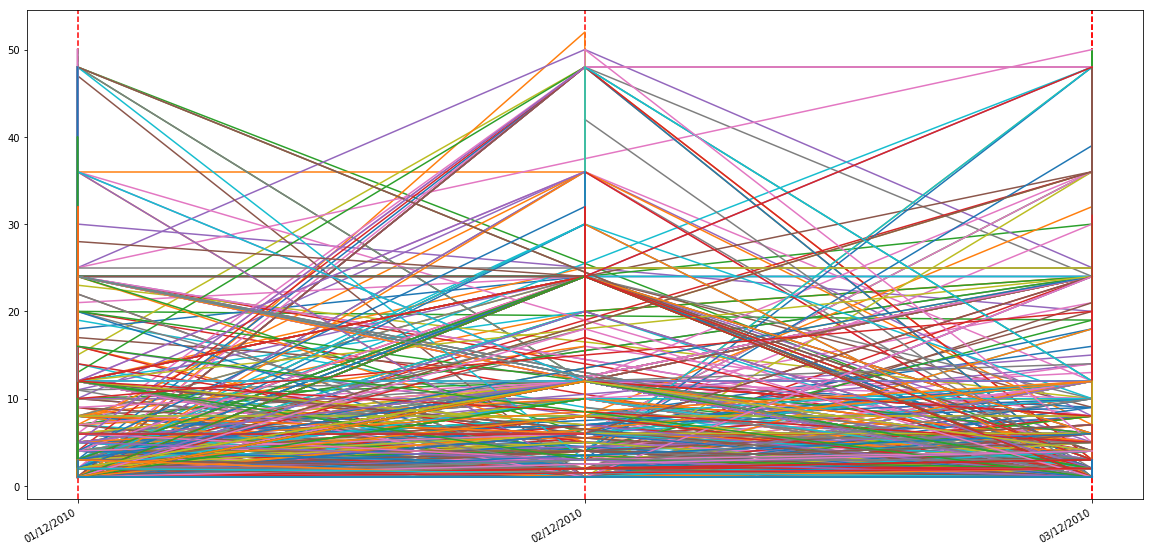

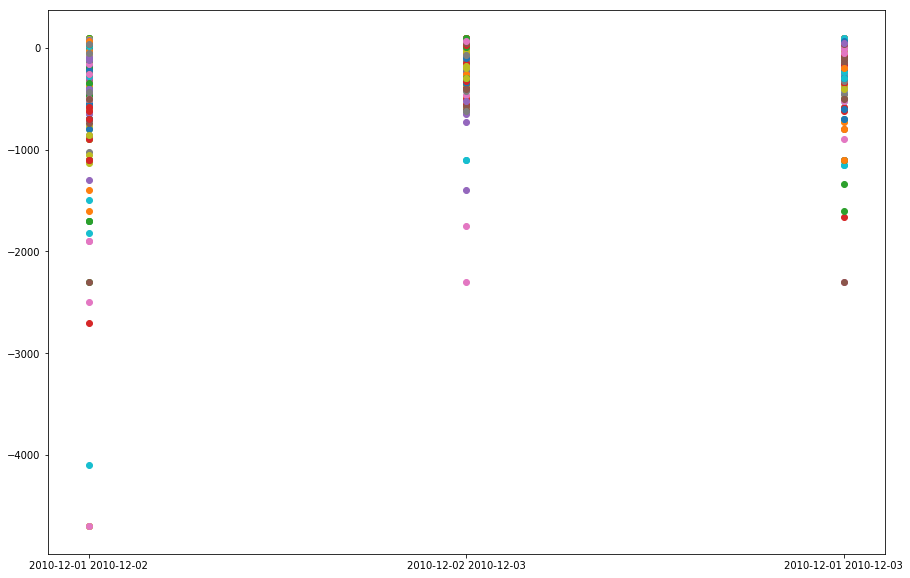

In [244]:
variation("22212",dataCluster)
elasCroisee("22212",dataCluster)
draw_elasticity("22212",dataCluster)

# III Visualisation du graphe client / produit. 

# III.1 Top_K

1) Nous allons d'abord calculer les top-k des clients qui ont acheté plus de produits/qui ont dépensé plus

   # Top_k function
    descript : Elle permet de calculer le top k des clients en fonction de la quantité et du montant achetés
    params:
        k ={Desc: le nombre de top, Type: int}
        data= {Desc: la base des transactions,Type : DataFrame}
    output :
         top_k1 ={ Desc : top k selon le montant total acheté, Type: DataFrame}
         top_k2 = {Desc: top k selon la quantité totale achetée, Type : DtaFrame}
  

In [264]:
def top_k(k, data):
    client_produit= data[['CustomerID','UnitPrice','Quantity']] #
    client_produit["Montant"] = client_produit["UnitPrice"] *client_produit["Quantity"]
    client_produit = client_produit[['CustomerID','Quantity','Montant']].groupby('CustomerID').agg("sum")
    top_k1 = client_produit.sort_values(by=['Montant'], ascending=False).head(k)
    top_k2 = client_produit.sort_values(by=['Quantity'], ascending=False).head(k)
    return top_k1,top_k2

  # get_node_edges_color function
    description : Elle permet de définir les noeuds, et les liens entre les noeuds
    params:
        top_k ={Desc: top k calculer à aprtir de la fonction précedente, Type: DataFrame}
        data= {Desc: la base des transactions,Type : DataFrame}
    output :
         customerId ={ Desc : les identifiants du top k clients, Type: list}
         stock_code = {Desc: les produits achetés par le top K, Type : list}
         edges = {Desc: les liens client-produit, Type : list}
         color = {Desc: coleurs des noeuds, Type : list}

In [257]:
import networkx as nx
def get_node_edges_color(top_k,data):
    customerId =top_k.index.values.tolist()
    topk_customer = data[data["CustomerID"].isin(customerId)]
    stock_code = topk_customer["StockCode"].drop_duplicates().values.tolist()
    topk_customergr = topk_customer[["CustomerID","StockCode","Quantity"]].groupby(["CustomerID","StockCode"]).agg("sum")
    edges = topk_customergr.index.tolist()
    width = topk_customergr.values.tolist()
    color = [ 'blue' for id in  customerId ]
    for p in stock_code :
        color.append('green')
        
    return customerId,stock_code,edges,color


   # draw_customer_product function
   
    descript : Elle permet de visualiser le graphe non orienté de client-produits
    params:
         nodes1 ={ Desc : les identifiants du top k clients, Type: list}
         nodes2 = {Desc: les produits achetés par le top K, Type : list}
         edges = {Desc: les liens client-produit, Type : list}
         color = {Desc: coleurs des noeuds, Type : list}
    output :
         customerId ={ Desc : les identifiants du top k clients, Type: list}
         stock_code = {Desc: les produits achetés par le top K, Type : list}
         edges = {Desc: les liens client-produit, Type : list}
         color = {Desc: coleurs des noeuds, Type : list}

In [278]:
def draw_customer_product(nodes1,nodes2,edges,color):
    G = nx.Graph()
    G.clear()
    plt.figure(figsize=(20,15))
    G.add_nodes_from(nodes1)
    G.add_nodes_from(nodes2)
    G.add_edges_from(edges)
    nx.draw(G, with_labels=True, node_color= color)
    plt.legend(labels =["Clients","liens"])
    plt.show()

    # Nous allons afficher le top 5  

In [268]:
topk,topk2 = top_k(5, data)
print("######top_k1########")
print(topk)
print("######top_k2########")
print(topk2)

######top_k1########
            Quantity    Montant
CustomerID                     
14646.0       196915  280206.02
18102.0        64124  259657.30
17450.0        69993  194550.79
16446.0        80997  168472.50
14911.0        80265  143825.06
######top_k2########
            Quantity    Montant
CustomerID                     
14646.0       196915  280206.02
16446.0        80997  168472.50
14911.0        80265  143825.06
12415.0        77374  124914.53
12346.0        74215   77183.60


Il y a trois clients qui sont à la fois dans les deux top_5

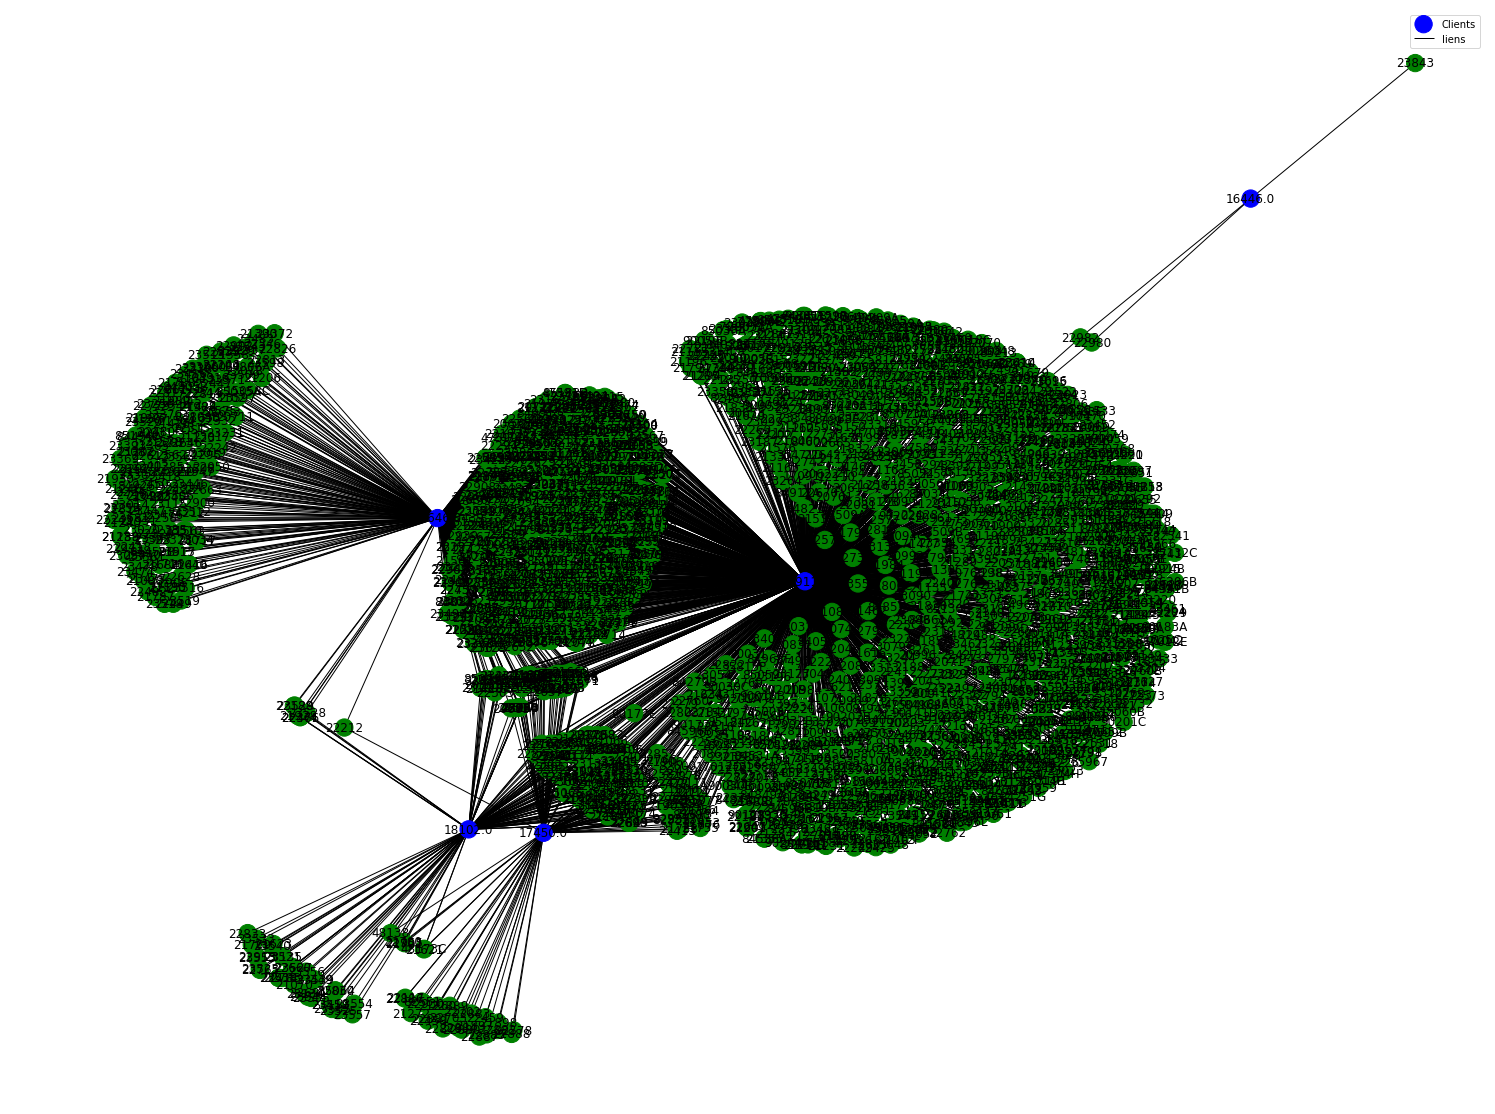

In [281]:
#Visualisation du graphe pour le top_5 1
nodes1,nodes2,edges,color = get_node_edges_color(topk,data)
draw_customer_product(nodes1,nodes2,edges,color)

Nous avons remarqué que le client 16446 qui n'achète que 3 produits contraiment au client 14646.

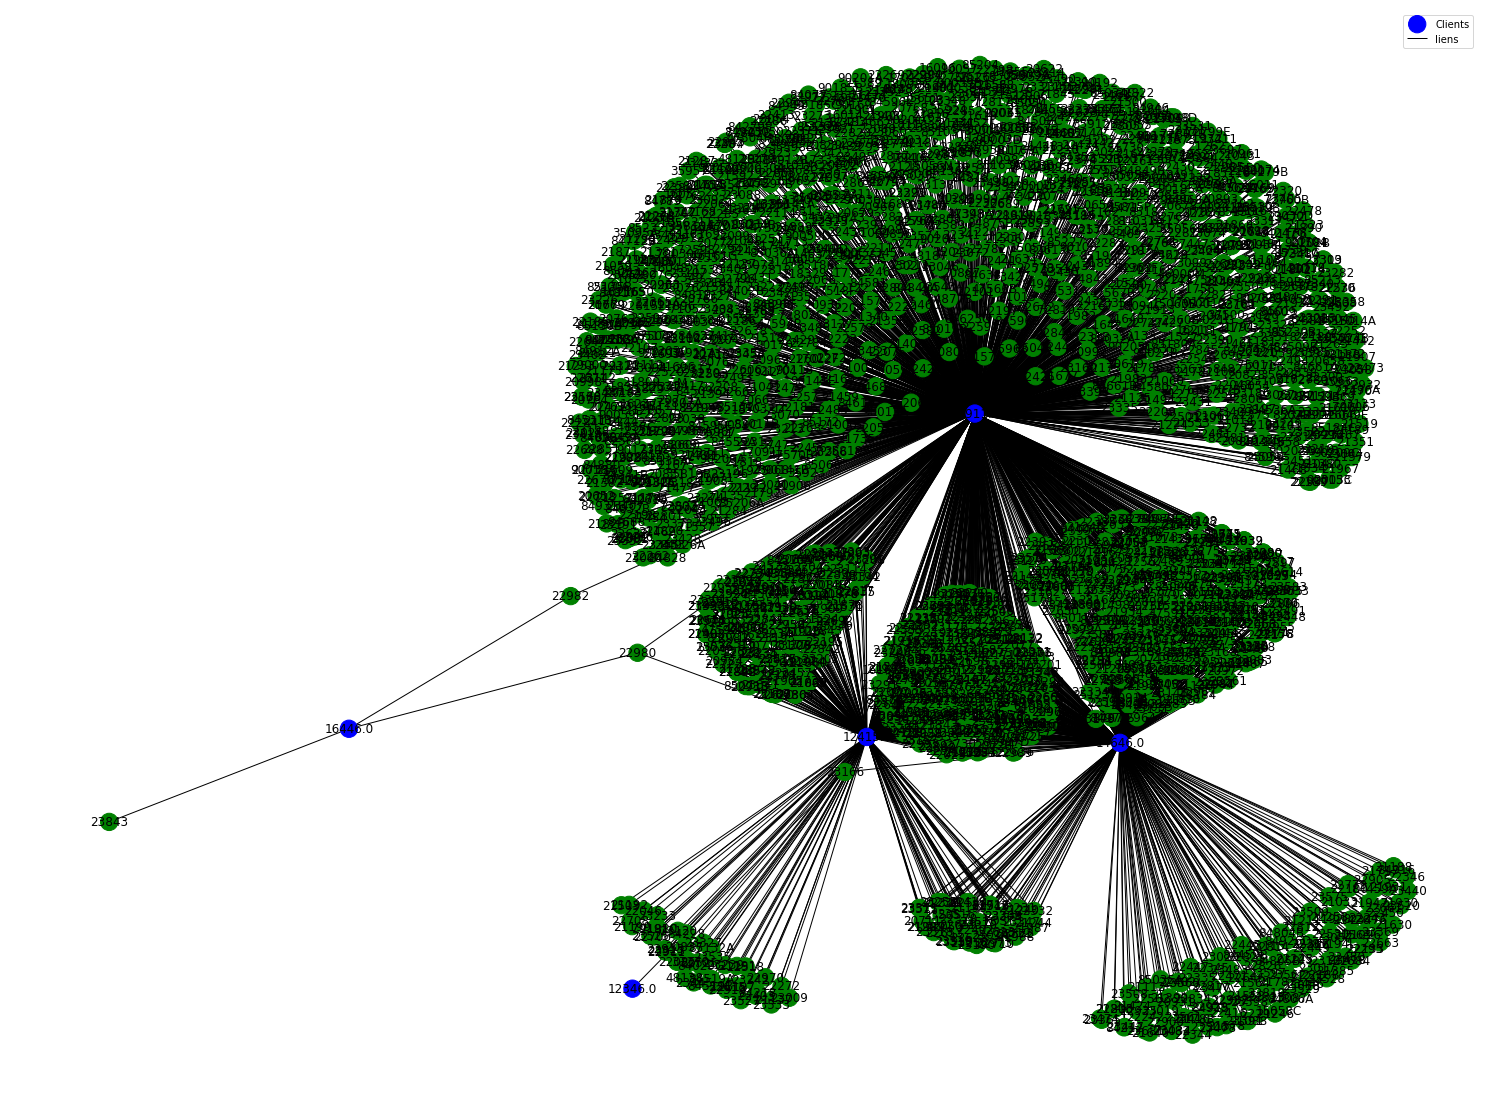

In [280]:
nodes1,nodes2,edges,color = get_node_edges_color(topk2,data)
draw_customer_product(nodes1,nodes2,edges,color)

# FD######################################################FD